# Cleaning Airbnb data for Denver

Source of data: http://insideairbnb.com/get-the-data.html

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Listing Data

In [17]:
file_listing = '../../Data/VacationPlanner/listings.csv.gz'
listing = pd.read_csv(file_listing)
print('Number of entries: {:d}'.format(listing.shape[0]))
print('Number of columns: {:d}'.format(listing.shape[1]))
print('The columns are:')
listing.columns

Number of entries: 4984
Number of columns: 96
The columns are:


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

#### Columns of interest:

There are too many columns in the original data set, which are not relevant to the task. So I trim the dataset to the interesting columns that I care about. 




In [18]:
columns = ['id', 'host_id', 'host_is_superhost', 'neighbourhood_cleansed', 
           'zipcode', 'latitude', 'longitude', 'is_location_exact', 'room_type', 
           'accommodates', 'bathrooms', 'beds', 'price', 'cleaning_fee', 
           'review_scores_rating', 'number_of_reviews']
listing = listing[columns]

# Brief look at the data
listing.head()

,id,host_id,host_is_superhost,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,room_type,accommodates,bathrooms,beds,price,cleaning_fee,review_scores_rating,number_of_reviews
0,360,666,t,Highland,80211.0,39.767033,-105.002564,t,Entire home/apt,5,1.0,2.0,$140.00,$35.00,100.0,3
1,590,933,t,North Park Hill,80207.0,39.753609,-104.912373,t,Private room,3,1.0,1.0,$61.00,$10.00,96.0,540
2,592,933,t,North Park Hill,80207.0,39.754380,-104.911557,t,Private room,2,1.0,1.0,$42.00,$10.00,97.0,142
3,686,990,t,North Capitol Hill,80203.0,39.745030,-104.977564,t,Private room,2,2.0,1.0,$70.00,$10.00,95.0,232
4,1940,2150,t,Baker,80223.0,39.719810,-104.996487,t,Entire home/apt,2,1.0,1.0,$95.00,$75.00,99.0,21


In [19]:
# Columns types
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4984 entries, 0 to 4983
Data columns (total 16 columns):
id                        4984 non-null int64
host_id                   4984 non-null int64
host_is_superhost         4984 non-null object
neighbourhood_cleansed    4984 non-null object
zipcode                   4916 non-null float64
latitude                  4984 non-null float64
longitude                 4984 non-null float64
is_location_exact         4984 non-null object
room_type                 4984 non-null object
accommodates              4984 non-null int64
bathrooms                 4981 non-null float64
beds                      4982 non-null float64
price                     4984 non-null object
cleaning_fee              4350 non-null object
review_scores_rating      4338 non-null float64
number_of_reviews         4984 non-null int64
dtypes: float64(6), int64(4), object(6)
memory usage: 623.1+ KB


### Missing entries

Count the number of missing entry in each column

In [20]:
# No of missing entries in each columns
print('Number of entries is {0:d} '.format(listing.shape[0]))

listing.isnull().sum()

Number of entries is 4984 


id                          0
host_id                     0
host_is_superhost           0
neighbourhood_cleansed      0
zipcode                    68
latitude                    0
longitude                   0
is_location_exact           0
room_type                   0
accommodates                0
bathrooms                   3
beds                        2
price                       0
cleaning_fee              634
review_scores_rating      646
number_of_reviews           0
dtype: int64

### Data Cleaning

1. Drop the column zipcode and is_location_exact. Location information from latitude, longitude and neighbourhood_cleansed should be sufficient for the task.
2. Drop entries with missing values in bathrooms and beds.
3. Replane Nan in cleaning_fee to 0
4. Replace host_is_superhost values with t:1 and f:0
5. Format price and cleaning_fee to float. 
6. Set id as dataframe index
7. Remove luxury listing (price >9998)

In [21]:
# Drop zipcode and is_location_exact column
listing = listing.drop(columns=['zipcode', 'is_location_exact'])

# Drop entries with missing values in bathrooms and beds
og_len = listing.shape[0]
listing = listing.dropna(how='any', subset=['bathrooms', 'beds'])


# Replace NaN in cleaning price
listing['cleaning_fee'] = listing['cleaning_fee'].fillna('0')

# Make host_is_superhost binary
listing = listing.replace({'host_is_superhost':{'t':1, 'f':0}})

# Format price and cleaning_free
listing[['price', 'cleaning_fee']] = listing[['price', 'cleaning_fee']].replace(
                                    '[\$,]', '', regex=True).astype(float)

# Remove luxury entries
listing = listing[listing['price']<9998]
print('Number of entries dropped: {0:d}'.format(og_len - listing.shape[0]))
print('Number of remaining entries: {0:d}'.format(listing.shape[0]))

# Set id as index
listing = listing.set_index('id')

Number of entries dropped: 13
Number of remaining entries: 4971


## Calendar data

In [22]:
file_calendar = '../../Data/VacationPlanner/calendar.csv.gz'
calendar = pd.read_csv(file_calendar)
print('Number of entries: {:d}'.format(calendar.shape[0]))
print('Number of columns: {:d}'.format(calendar.shape[1]))
print('The columns are:')
calendar.head()

Number of entries: 1819160
Number of columns: 4
The columns are:


,listing_id,date,available,price
0,360,2019-08-22,t,$149.00
1,360,2019-08-21,t,$149.00
2,360,2019-08-20,t,$149.00
3,360,2019-08-19,t,$149.00
4,360,2019-08-18,t,$149.00


### Missing entries

In [23]:
calendar.isnull().sum()

listing_id          0
date                0
available           0
price         1112781
dtype: int64

### Data cleaning

1. Drop available. Available has t or f values. When available == 'f', price shows a NaN value. So available is redundant
2. Drop all entries with NaN
3. Convert price to numeric format
4. Convert data to numpy date time format
5. Rename listing_id to id

In [24]:
# Drop available
calendar = calendar.drop(columns=['available'])

# Drop NaN entries
og_len = calendar.shape[0]
calendar = calendar.dropna(how='any', subset=['price'])
print('Number of entries dropped: {0:d}'.format(og_len - calendar.shape[0]))
print('Number of remaining entries: {0:d}'.format(listing.shape[0]))

# Format price and cleaning_free
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)

# Convert date-time format
calendar['date'] = pd.to_datetime(calendar['date'], yearfirst=True)

# Rename 
calendar = calendar.rename(index=str, columns={'listing_id': 'id'})
calendar.info()

Number of entries dropped: 1112781
Number of remaining entries: 4971
<class 'pandas.core.frame.DataFrame'>
Index: 706379 entries, 0 to 1819151
Data columns (total 3 columns):
id       706379 non-null int64
date     706379 non-null datetime64[ns]
price    706379 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 21.6+ MB


In [25]:
calendar.groupby(['date']).size().reset_index(name='counts').head(5)

,date,counts
0,2018-08-27,1093
1,2018-08-28,1315
2,2018-08-29,1305
3,2018-08-30,1006
4,2018-08-31,635


In [26]:
median_price = calendar.groupby('id')['price'].median().reset_index(name='price')
median_price = median_price.set_index('id')

## Data Exploration

Trying to look at some general trends and structure in the data. While also gaining some insight into the data

##### Number of apartments vs accomodates

We can observe that apartments with accomodates of multiple of two are more popular. I would guess that this is because most listing would use a standard bed which accommodates two people. So the number of accommodates goes along with it. And fewer apartments have bed/couch for single person. 

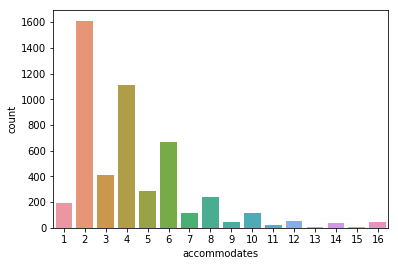

In [27]:
sns.countplot(x='accommodates', data=listing)


In [37]:
ax = sns.distplot(listing[listing['accommodates'] == 2 & listing['price']<300]['price'],
             bins=30, kde=False, rug=True)
# ax.set_xlim(0,250)

TypeError: cannot compare a dtyped [float64] array with a scalar of type [bool]

In [40]:
listing['price']<300

id
360          True
590          True
592          True
686          True
1940         True
2086         True
21745        True
21746        True
31503        True
39405        True
41284        True
56185       False
58598        True
59631        True
74125        True
81540        True
90307        True
98008        True
142683       True
172196      False
177942       True
182353       True
192430       True
217715       True
236207       True
242859       True
286732       True
287392       True
327500       True
343936      False
            ...  
27962395     True
27962414     True
27962912     True
27963397     True
27964190     True
27964276     True
27965325     True
27978719     True
27980482    False
27981947     True
27984091     True
27987870     True
27990562     True
27992799     True
28003000    False
28003130     True
28004534     True
28006110     True
28010484    False
28010762     True
28011375     True
28014823     True
28024516     True
28027135     True
2802827

In [29]:
listing['price'].sort_values()

id
25487102      10.0
20466746      10.0
27806196      15.0
21982186      15.0
9445553       18.0
9135545       18.0
13579869      18.0
11250449      19.0
14872688      19.0
24014283      19.0
16208547      19.0
20496416      19.0
24034673      19.0
24224176      19.0
24252808      19.0
24224042      19.0
24233921      19.0
20496667      19.0
24223925      19.0
24252736      19.0
24252780      19.0
24490571      19.0
24223535      19.0
24224177      19.0
27233505      20.0
27557576      20.0
6623752       20.0
23615021      20.0
20949492      20.0
25471033      20.0
             ...  
24058066     800.0
12890649     800.0
24848902     800.0
4350744      875.0
23312555     899.0
18052024     990.0
9944575      995.0
18049607     999.0
24854686     999.0
27699490     999.0
17639310     999.0
26987056     999.0
22064284     999.0
14296973     999.0
27059603     999.0
27980482     999.0
27165242     999.0
27781713     999.0
20426353    1095.0
14841000    1100.0
25461596    1200.0
24575556 

In [30]:
listing[listing['price'] == 9999]

,host_id,host_is_superhost,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms,beds,price,cleaning_fee,review_scores_rating,number_of_reviews
id,,,,,,,,,,,,,
